In [1]:
import cv2
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import label
import imageio
from IPython.display import Image
from scipy import interpolate

path = 'Fantastic Driver Slow Motion Swings of World Top 10.mp4'
cap = cv2.VideoCapture(path)

In [2]:
Count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
Width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
Height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

print(Count, Width, Height)

4905 1280 720


In [121]:
start_frame, end_frame = 200, 600
# start_frame, end_frame = 1100, 1500

cap = cv2.VideoCapture(path)
cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame - 1)
res = np.empty((end_frame - start_frame, Height, Width, 3)).astype(np.uint8)
idx = 0

while(idx < end_frame - start_frame):
    ret, frame = cap.read()
    if not ret:
        print('No frames grabbed!')
        break
    res[idx,:,:,:] = frame[:,:,[2,1,0]]
    idx +=1
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
res = res[:,50:720,0:620,:]
# res = res[:,50:720,620:1280,:]

cap.release()

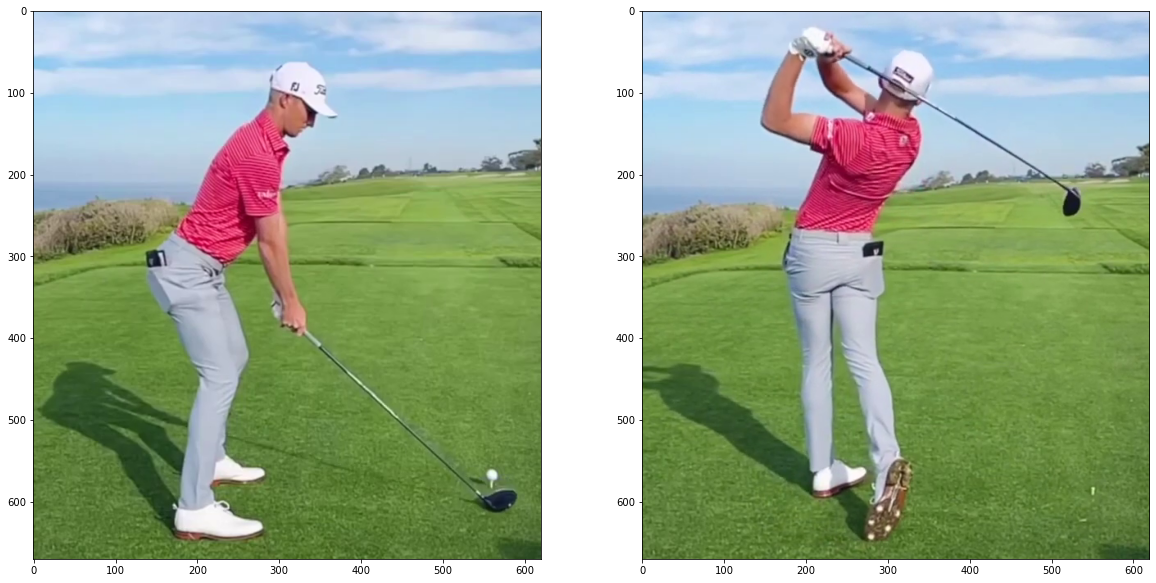

In [122]:
plt.figure(figsize=(20,20))
plt.subplot(1,2,1)
plt.imshow(res[0,:,:,:])
plt.subplot(1,2,2)
plt.imshow(res[-1,:,:,:])
plt.show()

In [130]:
def find_ball(img):
    center = (-1, -1)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray,(11,11),0)
    _, white = cv2.threshold(gray,200,255,cv2.THRESH_BINARY)
    
    labeled_array, num_features = label(white)
    islands, cnts = np.unique(labeled_array, return_counts = True)
    ball_like_img = labeled_array.copy()
    
    for idx, cnt in zip(islands, cnts):
        if (cnt > 100) or (cnt < 40):
            ball_like_img[ball_like_img==idx] = 0
    ball_like_img[ball_like_img!=0] = 255
    
    contours, hierarchy = cv2.findContours(ball_like_img.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for idx, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, closed=True)
        borders = cv2.approxPolyDP(curve=contour,epsilon=0.055*perimeter,closed=True)

        if len(borders) > 4: # Circle
            (x1,y1),r = cv2.minEnclosingCircle(contour)
            area_circle = r*r*np.pi
            if area / area_circle > 0.6:
                center = (x1,y1)
                img = cv2.drawContours(img, [contour], -1, color=(255, 0, 0), thickness=cv2.FILLED)
                img = cv2.circle(img, (int(x1), int(y1)), int(r), (0,255,0), 2)
            
    return img, ball_like_img, center

In [131]:
# img, ball_like_img, center, white = find_ball(res[100,:,:,:].copy())
# plt.figure(figsize=(20,20))
# plt.subplot(1,2,1)
# plt.imshow(white)
# plt.subplot(1,2,2)
# plt.imshow(img)

In [132]:
tracking_orig = res.copy()
center_pts = []
for idx_img, img in enumerate(tqdm(tracking_orig)):
    result_img, mask, center = find_ball(img)
    center_pts.append(center)
    tracking_orig[idx_img,:,:,:] = result_img

100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:04<00:00, 98.43it/s]


In [133]:
# save_name = 'test'
# imageio.mimsave(f'{save_name}.gif', tracking_orig, fps=30)

In [134]:
# Image(url='test.gif')

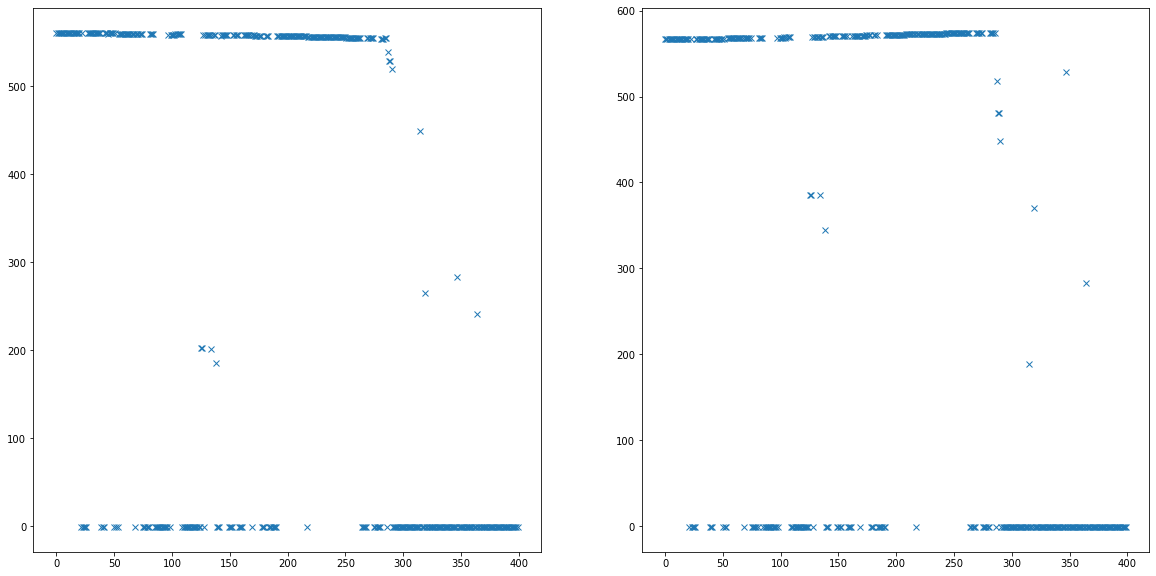

In [135]:
pts_range = np.arange(len(center_pts))
x = np.array(center_pts)[:,0]
y = np.array(center_pts)[:,1]

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(pts_range, x, "x")
plt.subplot(1,2,2)
plt.plot(pts_range, y, "x")
plt.show()

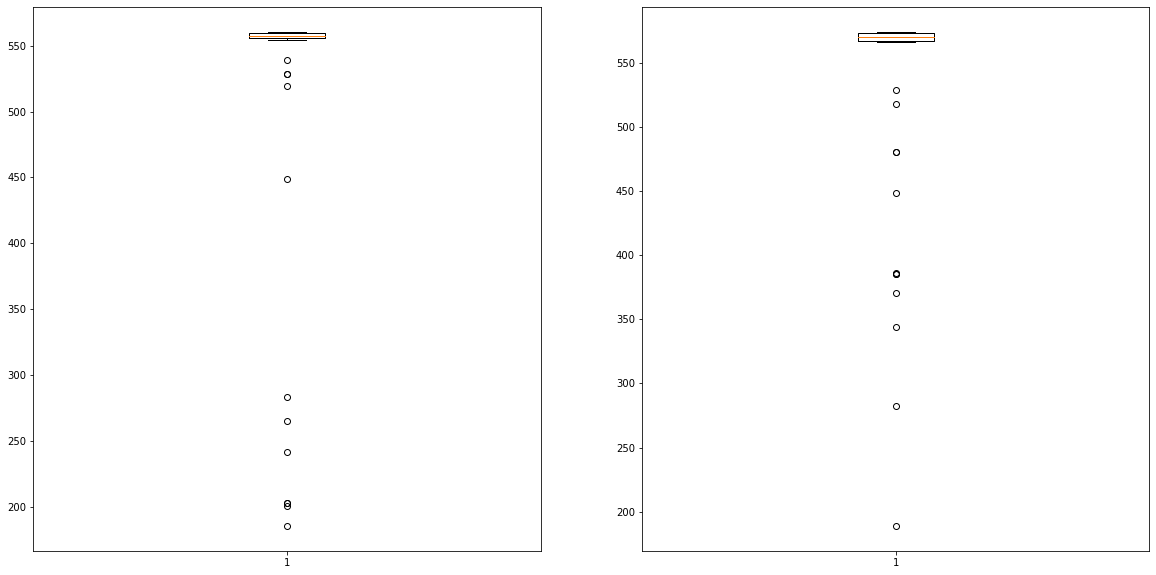

In [136]:
x_ = np.array([i for i in x if i!=-1])
y_ = np.array([i for i in y if i!=-1])

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.boxplot(x_)
plt.subplot(1,2,2)
plt.boxplot(y_)
plt.show()

In [137]:
iqr = np.quantile(x_, 0.75) - np.quantile(x_, 0.25)
max_x = np.quantile(x_, 0.75)+(1.5*iqr)
min_x = np.quantile(x_, 0.25)-(1.5*iqr)
x_without_outliers = x_[(x_ >= min_x) & (x_ <= max_x)]

iqr = np.quantile(y_, 0.75) - np.quantile(y_, 0.25)
max_y = np.quantile(y_, 0.75)+(1.5*iqr)
min_y = np.quantile(y_, 0.25)-(1.5*iqr)
y_without_outliers = y_[(y_ >= min_y) & (y_ <= max_y)]

In [138]:
### X
frame_id_before_shoot = np.where(x==x_without_outliers[-1])[0][-1]

x_before_shoot = x[:frame_id_before_shoot + 1]
x_before_shoot[x_before_shoot<min_x] = -1

pts = [(idx, x_pts) for idx, x_pts in enumerate(x_before_shoot) if x_pts!=-1]

xx_pts = np.array(pts)[:,0]
xy_pts = np.array(pts)[:,1]
f = interpolate.interp1d(xx_pts, xy_pts)

xnew_x = np.arange(len(x_before_shoot))
ynew_x = f(xnew_x)

### Y
y_before_shoot = y[:frame_id_before_shoot + 1]
y_before_shoot[y_before_shoot<min_y] = -1

pts = [(idx, y_pts) for idx, y_pts in enumerate(y_before_shoot) if y_pts!=-1]

yx_pts = np.array(pts)[:,0]
yy_pts = np.array(pts)[:,1]
f = interpolate.interp1d(yx_pts, yy_pts)

xnew_y = np.arange(len(y_before_shoot))
ynew_y = f(xnew_y)

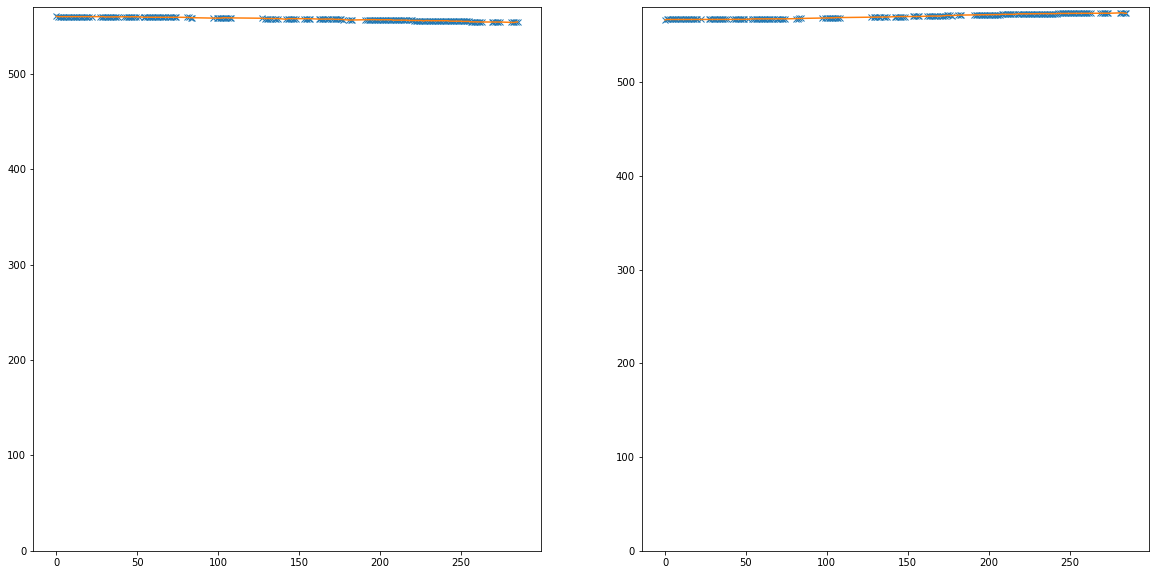

In [139]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(xx_pts, xy_pts, "x")
plt.plot(xnew_x, ynew_x, '-')
plt.ylim([0,570])

plt.subplot(1,2,2)
plt.plot(yx_pts, yy_pts, "x")
plt.plot(xnew_y, ynew_y, '-')
plt.ylim([0,580])

plt.show()

In [140]:
def plot_ball_center(img, center, r=6):
    x1,y1 = center
    return cv2.circle(img.copy(), (int(x1), int(y1)), int(r), (255,0,255), 2)

In [141]:
tracking_before_shoot = res.copy()[:frame_id_before_shoot + 1]
pts_corrected = [(i,j) for i,j in zip(ynew_x, ynew_y)]

for idx_img, img in enumerate(tqdm(tracking_before_shoot)):
    result_img = plot_ball_center(img, pts_corrected[idx_img])
    tracking_before_shoot[idx_img,:,:,:] = result_img

100%|██████████████████████████████████████████████████████████████████████████████| 286/286 [00:00<00:00, 2701.99it/s]


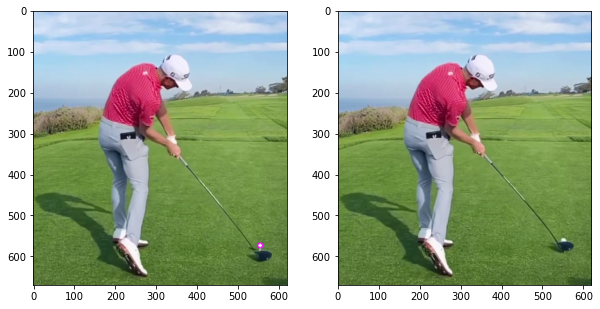

In [142]:
idx = 285

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(tracking_before_shoot[idx,:,:,:])
plt.subplot(1,2,2)
plt.imshow(res[idx+1,:,:,:])
plt.show()

In [143]:
# save_name = 'test_tracking'
# imageio.mimsave(f'{save_name}.gif', tracking_before_shoot, fps=30)

In [144]:
# Image(url='test_tracking.gif')

In [145]:
idx_non_zeros = [idx for idx, i in enumerate(x[frame_id_before_shoot:]) if i!=-1]
pts = np.array([(i,j) for i,j in zip(x[frame_id_before_shoot:],y[frame_id_before_shoot:]) if (i,j)!=(-1,-1)])
idx_non_zeros

[0, 2, 3, 4, 5, 30, 34, 62, 79]

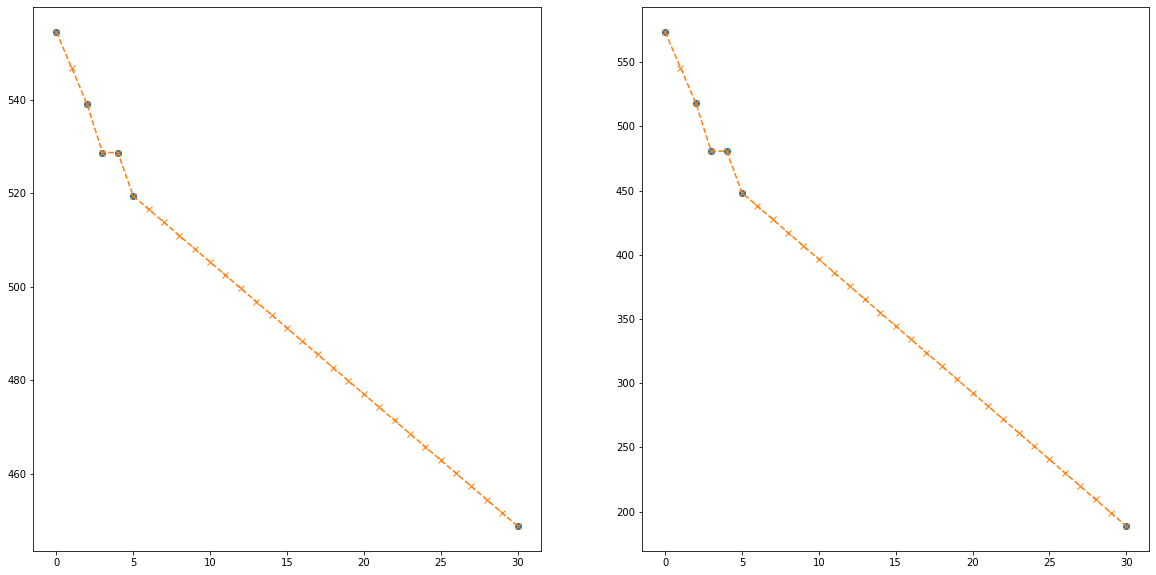

In [146]:
def calculate_angle(pt):
    v0 = pt[1,:] - pt[0,:]
    v1 = pt[2,:] - pt[1,:]
    angle = np.math.atan2(np.linalg.det([v0,v1]), np.dot(v0,v1))
    return np.degrees(angle)

def filter_trajectory(pts, idx_non_zeros):
    angle = [0, 0] + [calculate_angle(pts[idx:idx+3]) for idx in range(len(pts)-2)]
    pts = [(p, idx) for p,idx,a in zip(pts, idx_non_zeros,angle) if abs(a)<15]
    x = [i[0][0] for i in pts]
    y = [i[0][1] for i in pts]
    id_ = [i[1] for i in pts]
    return x, y, id_

x_filtered, y_filtered, id_filtered = filter_trajectory(pts, idx_non_zeros)
xs = np.arange(31)

cs_x = interpolate.interp1d(id_filtered, x_filtered)
cs_y = interpolate.interp1d(id_filtered, y_filtered)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(id_filtered, x_filtered, "o")
plt.plot(xs, cs_x(xs), "x--")

plt.subplot(1,2,2)
plt.plot(id_filtered, y_filtered, "o")
plt.plot(xs, cs_y(xs), "x--")
plt.show()

In [147]:
tracking_after_shoot = res.copy()[frame_id_before_shoot:]
pts_corrected_30 = [(i,j) for i,j in zip(cs_x(xs), cs_y(xs))]

In [148]:
# save_name = 'test_tracking_after_shoot'
# imageio.mimsave(f'{save_name}.gif', tracking_after_shoot, fps=1)

In [149]:
# Image(url='test_tracking_after_shoot.gif')

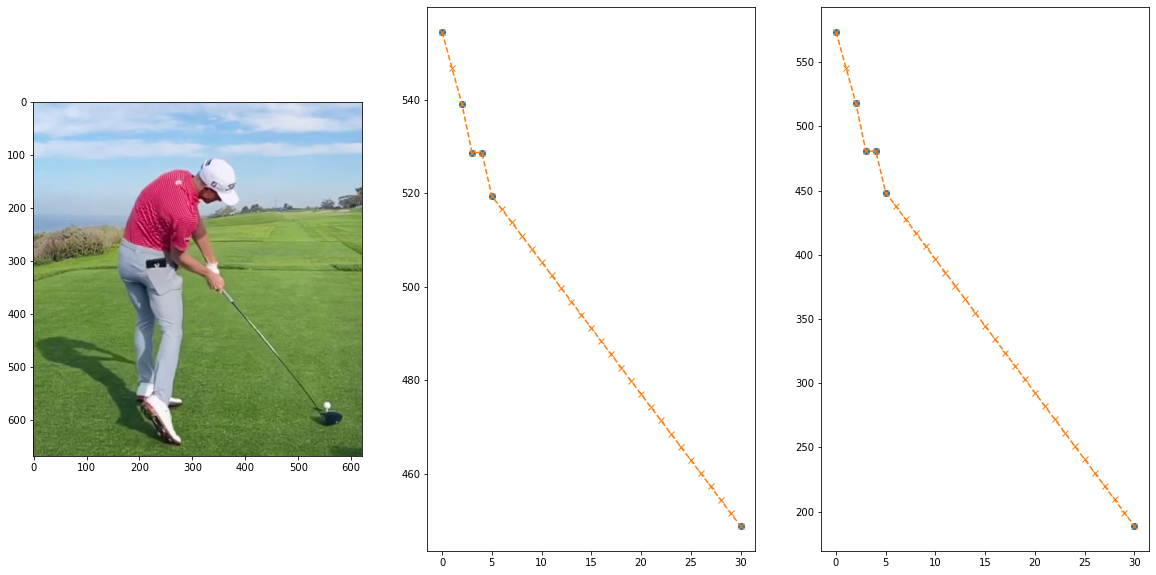

In [150]:
idx = 0
tracking_after_shoot = res.copy()[frame_id_before_shoot:]

x_traj = cs_x(xs)
y_traj = cs_y(xs)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(tracking_after_shoot[idx,:,:,:])
plt.subplot(1,3,2)
plt.plot(id_filtered, x_filtered, "o")
plt.plot(xs, x_traj, "x--")
plt.subplot(1,3,3)
plt.plot(id_filtered, y_filtered, "o")
plt.plot(xs, y_traj, "x--")
plt.show()

In [151]:
 def filter_image_trajectory(img, x, y, offset_x = 20, offset_y = 35):
    square = img.copy()[int(y-2*offset_y):int(y+50), int(x-offset_x):int(x+offset_x)]
    return square

def stricter_thresholding(img):
    gray = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray,(11,11),0)
    _, white = cv2.threshold(gray,175,255,cv2.THRESH_BINARY)
    
    labeled_array, num_features = label(white)
    islands, cnts = np.unique(labeled_array, return_counts = True)
    ball_like_img = labeled_array.copy()
    
    for idx, cnt in zip(islands, cnts):
        if (cnt > 110) or (cnt < 4):
            ball_like_img[ball_like_img==idx] = 0
    ball_like_img[ball_like_img!=0] = 255
    return ball_like_img

def detect_ball(white):
    contours, _ = cv2.findContours(white.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return cv2.minEnclosingCircle(contours[0])

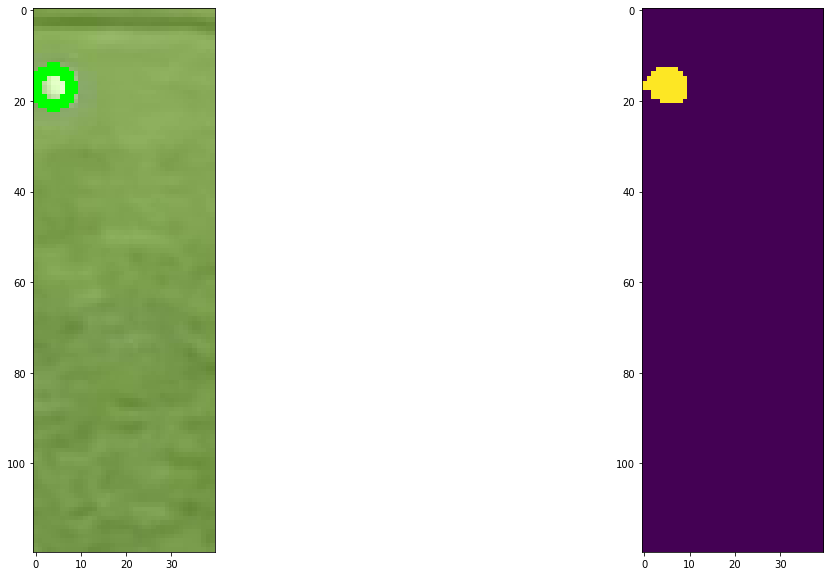

In [152]:
idx = 11
square = filter_image_trajectory(tracking_after_shoot[idx,:,:,:], x_traj[idx], y_traj[idx])
white = stricter_thresholding(square)
try:
    (x,y), r = detect_ball(white)
    square = cv2.circle(square, (int(x), int(y)), int(r), (0,255,0), 2)
except:
    pass

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(square)
plt.subplot(1,2,2)
plt.imshow(white)
plt.show()

In [153]:
after_shoot_traj = []
for idx, img in enumerate(tracking_after_shoot):
    try:
        square = filter_image_trajectory(img, x_traj[idx], y_traj[idx])
        white = stricter_thresholding(square)
    except:
        pass
    try:
        (x,y), r = detect_ball(white)
        x += x_traj[idx] - 20
        y += y_traj[idx] - 2*35
    except:
        (x,y) = (-1,-1)
    after_shoot_traj.append((x,y))
    pts = np.array([i for i in after_shoot_traj if i!=(-1,-1)]).astype(int)
    tracking_after_shoot[idx,:,:,:] = cv2.polylines(img, [pts], 0, (255,0,0), 2)

In [154]:
results = np.concatenate((tracking_before_shoot, tracking_after_shoot))

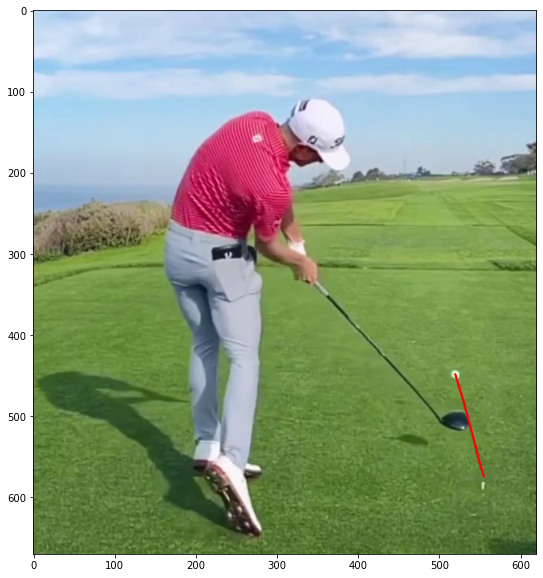

In [155]:
idx = 291

plt.figure(figsize=(20,10))
plt.imshow(results[idx,:,:,:])
plt.show()

In [156]:
save_name = 'tracking_result'
imageio.mimsave(f'{save_name}.gif', results, fps=30)

In [157]:
Image(url='tracking_result.gif')